## Importing Libraries


In [1]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard,LambdaCallback
from keras.layers import Input,Dropout, Dense,GlobalAveragePooling2D
from keras.models import Sequential,Model
from keras.applications.resnet import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from tqdm import tqdm
import seaborn as sns
import numpy as np
import itertools 
import datetime
from tensorflow.keras.applications import VGG19
import cv2
import os
import io

## Data Preperation
 
1.   Load all training and testing data

2.   Pre-processing images (apply opencv functions : bilateralFilter,applyColorMap,resize)

3.   Append images and labels into Python list

4.   Convert lists into numpy array and normalize images with devide by 255

5.   One Hot Encoding on the labels

6.   Dividing the dataset into Training and Validation sets





In [2]:


# labels = ['glioma', 'meningioma', 'notumor', 'pituitary']
labels = ['character_1_ka','character_2_kha','character_3_ga','character_4_gha','character_5_kna','character_6_cha','character_7_chha','character_8_ja','character_9_jha','character_10_yna','character_11_taamatar','character_12_thaa','character_13_daa','character_14_dhaa','character_15_adna','character_16_tabala','character_17_tha','character_18_da','character_19_dha','character_20_na','character_21_pa','character_22_pha','character_23_ba','character_24_bha','character_25_ma','character_26_yaw','character_27_ra','character_28_la','character_29_waw','character_30_motosaw','character_31_petchiryakha','character_32_patalosaw','character_33_ha','character_34_chhya','character_35_tra','character_36_gya','digit_0','digit_1','digit_2','digit_3','digit_4','digit_5','digit_6','digit_7','digit_8','digit_9']
x_train = [] # training images.
y_train  = [] # training labels.
x_test = [] # testing images.
y_test = [] # testing labels.

image_size = 48


for label in labels:
    trainPath = os.path.join('Handwritten/DevanagariHandwrittenCharacterDataset/Train',label)
    for file in tqdm(os.listdir(trainPath)):
        image = cv2.imread(os.path.join(trainPath, file),0) # load images in gray.
        image = cv2.bilateralFilter(image, 2, 50, 50) # remove images noise.
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE) # produce a pseudocolored image.
        image = cv2.resize(image, (image_size, image_size)) # resize images into 150*150.
        x_train.append(image)
        y_train.append(labels.index(label))
    
    testPath = os.path.join('Handwritten/DevanagariHandwrittenCharacterDataset/Test',label)
    for file in tqdm(os.listdir(testPath)):
        image = cv2.imread(os.path.join(testPath, file),0)
        image = cv2.bilateralFilter(image, 2, 50, 50)
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE)
        image = cv2.resize(image, (image_size, image_size))
        x_test.append(image)
        y_test.append(labels.index(label))


x_train = np.array(x_train) / 255.0 # normalize Images into range 0 to 1.
x_test = np.array(x_test) / 255.0

print(x_train.shape)
print(x_test.shape)

100%|██████████| 300/300 [00:00<00:00, 3370.03it/s]


(78200, 48, 48, 3)
(13800, 48, 48, 3)


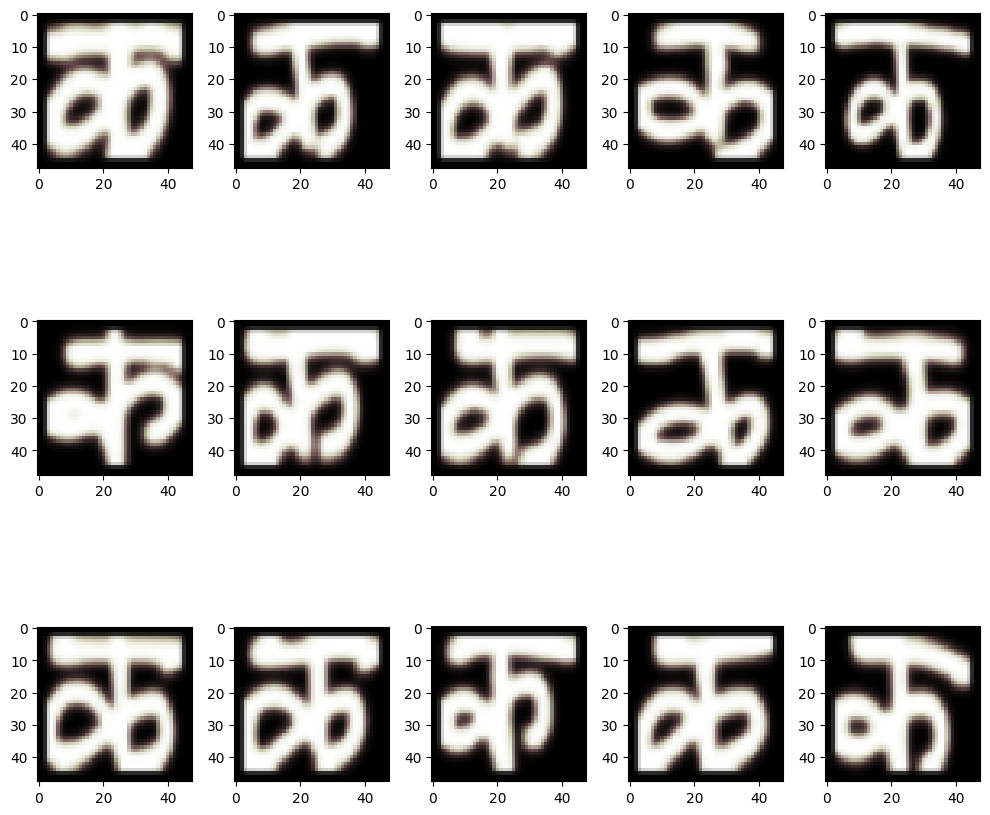

In [3]:

images = [x_train[i] for i in range(15)]
fig, axes = plt.subplots(3, 5, figsize = (10, 10))
axes = axes.flatten()
for img, ax in zip(images, axes):
    ax.imshow(img)
plt.tight_layout()
plt.show()

In [4]:
x_train, y_train = shuffle(x_train,y_train, random_state=42) 

y_train = tf.keras.utils.to_categorical(y_train) #One Hot Encoding on the labels
y_test = tf.keras.utils.to_categorical(y_test)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42) #Dividing the dataset into Training and Validation sets.

print(x_val.shape)

(15640, 48, 48, 3)


## Data Augmentation
In order to make the most of our few training examples, we will **augment** them via a number of random transformations, so that our model would never see twice the exact same picture. This helps prevent **overfitting** and helps the model generalize better.

In [5]:

# ImageDataGenerator transforms each image in the batch by a series of random translations, rotations, etc.
datagen = ImageDataGenerator(
    rotation_range=10,                        
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True)

# After you have created and configured your ImageDataGenerator, you must fit it on your data.
datagen.fit(x_train)

## Pre-trained Model
Deep convolutional neural network models may take days or even weeks to train on very large datasets.

A way to short-cut this process is to re-use the model weights from pre-trained models that were developed for standard computer vision benchmark datasets, such as the ImageNet image recognition tasks. Top performing models can be downloaded and used directly, or integrated into a new model for your own computer vision problems.


In this project, I'll be using the **ResNet50** model which will use the weights from the **ImageNet** dataset.




**Note**

Setting `include_top` to `False` moves all the layer's weights from trainable to non-trainable. This is called "freezing" the layer: the state of a frozen layer won't be updated during training



In [6]:
net = VGG19(
    weights='imagenet', # Load weights pre-trained on ImageNet.
     include_top=False, # Do not include the ImageNet classifier at the top.
     input_shape=(image_size,image_size,3))

**GlobalAveragePooling2D** -> This layer acts similar to the Max Pooling layer in CNNs, the only difference being is that it uses the Average values instead of the Max value while pooling. This really helps in decreasing the computational load on the machine while training.

**Dropout** -> This layer omits some of the neurons at each step from the layer making the neurons more independent from the neibouring neurons. It helps in avoiding overfitting. Neurons to be ommitted are selected at random. The rate parameter is the liklihood of a neuron activation being set to 0, thus dropping out the neuron

**Dense** -> This is the output layer which classifies the image into 1 of the 4 possible classes. It uses the softmax function which is a generalization of the sigmoid function.

In [7]:

model = net.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.4)(model)
model = Dense(46, activation="softmax")(model)
model = Model(inputs= net.input, outputs= model)

#compile our model.
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss = 'categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

## Log confusion matrix to TensorBoard

With the following code you can log the confusion matrix for all epochs.

In [8]:
%load_ext tensorboard


class_names = list(labels)
def plot_to_image(figure):    
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.close(figure)
    buf.seek(0)

    digit = tf.image.decode_png(buf.getvalue(), channels=4)
    digit = tf.expand_dims(digit, 0)

    return digit

def plot_confusion_matrix(cm, class_names): 
    figure = plt.figure(figsize=(8, 8)) 
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Accent) 
    plt.title("Confusion matrix") 
    plt.colorbar() 
    tick_marks = np.arange(len(class_names)) 
    plt.xticks(tick_marks, class_names, rotation=45) 
    plt.yticks(tick_marks, class_names)

    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)  
    threshold = cm.max() / 2. 

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):   
        color = "white" if cm[i, j] > threshold else "black"   
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)  
    
    plt.tight_layout() 
    plt.ylabel('True label') 
    plt.xlabel('Predicted label') 

    return figure

# Following function will make predictions from the model and log the confusion matrix as an image. 
def log_confusion_matrix(epoch, logs):
    predictions = np.argmax(model.predict(x_test), axis=1)
    cm = confusion_matrix(np.argmax(y_test,axis=1), predictions)
    figure = plot_confusion_matrix(cm, class_names=class_names)
    cm_image = plot_to_image(figure)
    
    with file_writer_cm.as_default():
        tf.summary.image("Confusion Matrix", cm_image, step=epoch)

# Remove previous log folder
!rm -fr logs
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

# Run tensorBoard
%tensorboard --logdir logs

'rm' is not recognized as an internal or external command,
operable program or batch file.


## Training
**callback** -> set of functions to be applied at given stages of the training procedure. You can use callbacks to get a view on internal states and statistics of the model during training.

**LambdaCallback** ->  will log the confusion matrix on every epoch.

**ModelCheckpoint** -> callback to save the Keras model or model weights at some frequency.

**EarlyStopping** -> stop training when a monitored metric has stopped improving.

**ReduceLROnPlateau** -> reduce learning rate when a metric has stopped improving.

In [9]:

#create a writer variable for writing into the log folder.
file_writer_cm = tf.summary.create_file_writer(logdir)

tensorboard = TensorBoard(logdir, histogram_freq=1)


BATCH_SIZE = 256
EPOCHS = 100

Checkpoint = ModelCheckpoint(filepath = 'model-{epoch:02d}-{val_accuracy:.2f}-{val_loss:.2f}.h5',monitor = 'val_loss', verbose = 1, save_best_only = True,mode = 'min')

ES = EarlyStopping(monitor = 'val_loss',min_delta = 0.001,patience = 5,mode = 'min',restore_best_weights = True,verbose = 1)

RL = ReduceLROnPlateau(monitor = 'val_loss',factor = 0.3,patience = 5,verbose = 1,mode = 'min')

callbacks = [ES,RL,tensorboard,Checkpoint,LambdaCallback(on_epoch_end=log_confusion_matrix)]

history = model.fit(datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),validation_data = (x_val,y_val),epochs = EPOCHS,callbacks = callbacks)


Epoch 1/100


245/245 [==============================] - ETA: 0s - loss: 0.8971 - accuracy: 0.7568
Epoch 1: val_loss improved from inf to 0.10226, saving model to model-01-0.97-0.10.h5


c:\Users\Jeyanand\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


245/245 [==============================] - 967s 4s/step - loss: 0.8971 - accuracy: 0.7568 - val_loss: 0.1023 - val_accuracy: 0.9714 - lr: 1.0000e-04
Epoch 2/100
245/245 [==============================] - ETA: 0s - loss: 0.1386 - accuracy: 0.9608
Epoch 2: val_loss improved from 0.10226 to 0.07261, saving model to model-02-0.98-0.07.h5


c:\Users\Jeyanand\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


245/245 [==============================] - 993s 4s/step - loss: 0.1386 - accuracy: 0.9608 - val_loss: 0.0726 - val_accuracy: 0.9789 - lr: 1.0000e-04
Epoch 3/100
245/245 [==============================] - ETA: 0s - loss: 0.0927 - accuracy: 0.9733
Epoch 3: val_loss improved from 0.07261 to 0.05700, saving model to model-03-0.98-0.06.h5


c:\Users\Jeyanand\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


245/245 [==============================] - 971s 4s/step - loss: 0.0927 - accuracy: 0.9733 - val_loss: 0.0570 - val_accuracy: 0.9835 - lr: 1.0000e-04
Epoch 4/100
245/245 [==============================] - ETA: 0s - loss: 0.0734 - accuracy: 0.9790
Epoch 4: val_loss improved from 0.05700 to 0.05612, saving model to model-04-0.98-0.06.h5


c:\Users\Jeyanand\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


245/245 [==============================] - 966s 4s/step - loss: 0.0734 - accuracy: 0.9790 - val_loss: 0.0561 - val_accuracy: 0.9835 - lr: 1.0000e-04
Epoch 5/100
245/245 [==============================] - ETA: 0s - loss: 0.0622 - accuracy: 0.9832
Epoch 5: val_loss did not improve from 0.05612
245/245 [==============================] - 957s 4s/step - loss: 0.0622 - accuracy: 0.9832 - val_loss: 0.0572 - val_accuracy: 0.9835 - lr: 1.0000e-04
Epoch 6/100
245/245 [==============================] - ETA: 0s - loss: 0.0576 - accuracy: 0.9840
Epoch 6: val_loss did not improve from 0.05612
245/245 [==============================] - 952s 4s/step - loss: 0.0576 - accuracy: 0.9840 - val_loss: 0.0584 - val_accuracy: 0.9840 - lr: 1.0000e-04
Epoch 7/100
245/245 [==============================] - ETA: 0s - loss: 0.0456 - accuracy: 0.9874
Epoch 7: val_loss improved from 0.05612 to 0.05388, saving model to model-07-0.99-0.05.h5


c:\Users\Jeyanand\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


245/245 [==============================] - 960s 4s/step - loss: 0.0456 - accuracy: 0.9874 - val_loss: 0.0539 - val_accuracy: 0.9853 - lr: 1.0000e-04
Epoch 8/100
245/245 [==============================] - ETA: 0s - loss: 0.0429 - accuracy: 0.9877
Epoch 8: val_loss improved from 0.05388 to 0.04809, saving model to model-08-0.99-0.05.h5


c:\Users\Jeyanand\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


245/245 [==============================] - 966s 4s/step - loss: 0.0429 - accuracy: 0.9877 - val_loss: 0.0481 - val_accuracy: 0.9875 - lr: 1.0000e-04
Epoch 9/100
245/245 [==============================] - ETA: 0s - loss: 0.0414 - accuracy: 0.9880
Epoch 9: val_loss improved from 0.04809 to 0.04439, saving model to model-09-0.99-0.04.h5


c:\Users\Jeyanand\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


245/245 [==============================] - 957s 4s/step - loss: 0.0414 - accuracy: 0.9880 - val_loss: 0.0444 - val_accuracy: 0.9876 - lr: 1.0000e-04
Epoch 10/100
245/245 [==============================] - ETA: 0s - loss: 0.0402 - accuracy: 0.9885
Epoch 10: val_loss improved from 0.04439 to 0.04213, saving model to model-10-0.99-0.04.h5


c:\Users\Jeyanand\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


245/245 [==============================] - 960s 4s/step - loss: 0.0402 - accuracy: 0.9885 - val_loss: 0.0421 - val_accuracy: 0.9884 - lr: 1.0000e-04
Epoch 11/100
245/245 [==============================] - ETA: 0s - loss: 0.0330 - accuracy: 0.9908
Epoch 11: val_loss did not improve from 0.04213
245/245 [==============================] - 962s 4s/step - loss: 0.0330 - accuracy: 0.9908 - val_loss: 0.0439 - val_accuracy: 0.9881 - lr: 1.0000e-04
Epoch 12/100
245/245 [==============================] - ETA: 0s - loss: 0.0351 - accuracy: 0.9896
Epoch 12: val_loss did not improve from 0.04213
245/245 [==============================] - 961s 4s/step - loss: 0.0351 - accuracy: 0.9896 - val_loss: 0.0492 - val_accuracy: 0.9868 - lr: 1.0000e-04
Epoch 13/100
245/245 [==============================] - ETA: 0s - loss: 0.0320 - accuracy: 0.9906
Epoch 13: val_loss improved from 0.04213 to 0.03473, saving model to model-13-0.99-0.03.h5


c:\Users\Jeyanand\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


245/245 [==============================] - 962s 4s/step - loss: 0.0320 - accuracy: 0.9906 - val_loss: 0.0347 - val_accuracy: 0.9900 - lr: 1.0000e-04
Epoch 14/100
245/245 [==============================] - ETA: 0s - loss: 0.0304 - accuracy: 0.9910
Epoch 14: val_loss did not improve from 0.03473
245/245 [==============================] - 957s 4s/step - loss: 0.0304 - accuracy: 0.9910 - val_loss: 0.0415 - val_accuracy: 0.9898 - lr: 1.0000e-04
Epoch 15/100
245/245 [==============================] - ETA: 0s - loss: 0.0289 - accuracy: 0.9916
Epoch 15: val_loss did not improve from 0.03473
245/245 [==============================] - 953s 4s/step - loss: 0.0289 - accuracy: 0.9916 - val_loss: 0.0363 - val_accuracy: 0.9898 - lr: 1.0000e-04
Epoch 16/100
245/245 [==============================] - ETA: 0s - loss: 0.0252 - accuracy: 0.9925
Epoch 16: val_loss did not improve from 0.03473
245/245 [==============================] - 955s 4s/step - loss: 0.0252 - accuracy: 0.9925 - val_loss: 0.0531 - val_

## Learning curves

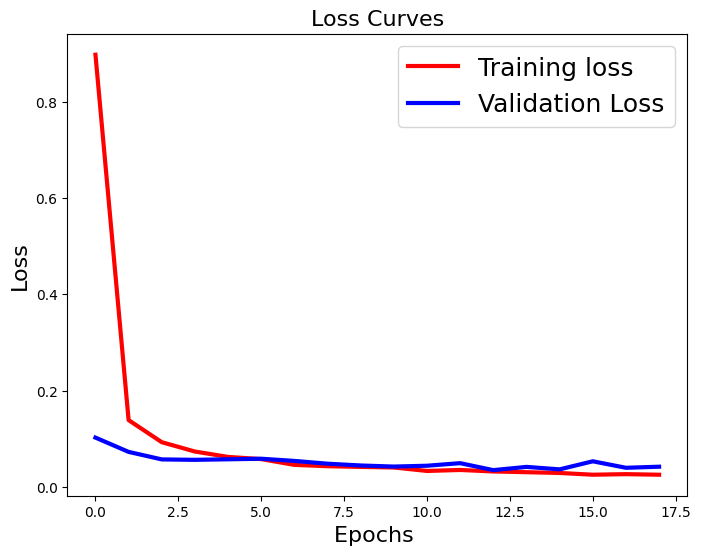

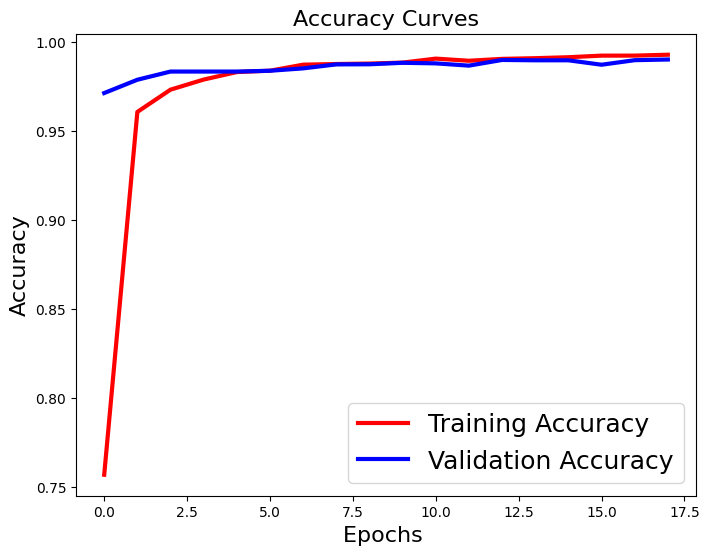

In [10]:
#Plot the Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
plt.show()

#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)   
plt.show()

## Evaluation

432/432 [==============================] - 61s 141ms/step
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       300
           1       1.00      0.99      0.99       300
           2       1.00      0.98      0.99       300
           3       0.97      1.00      0.98       300
           4       1.00      1.00      1.00       300
           5       1.00      1.00      1.00       300
           6       1.00      0.99      0.99       300
           7       0.99      1.00      1.00       300
           8       1.00      1.00      1.00       300
           9       1.00      1.00      1.00       300
          10       1.00      0.99      0.99       300
          11       0.98      1.00      0.99       300
          12       0.98      1.00      0.99       300
          13       0.98      0.97      0.97       300
          14       0.98      1.00      0.99       300
          15       0.99      1.00      0.99       300
          16       0.99

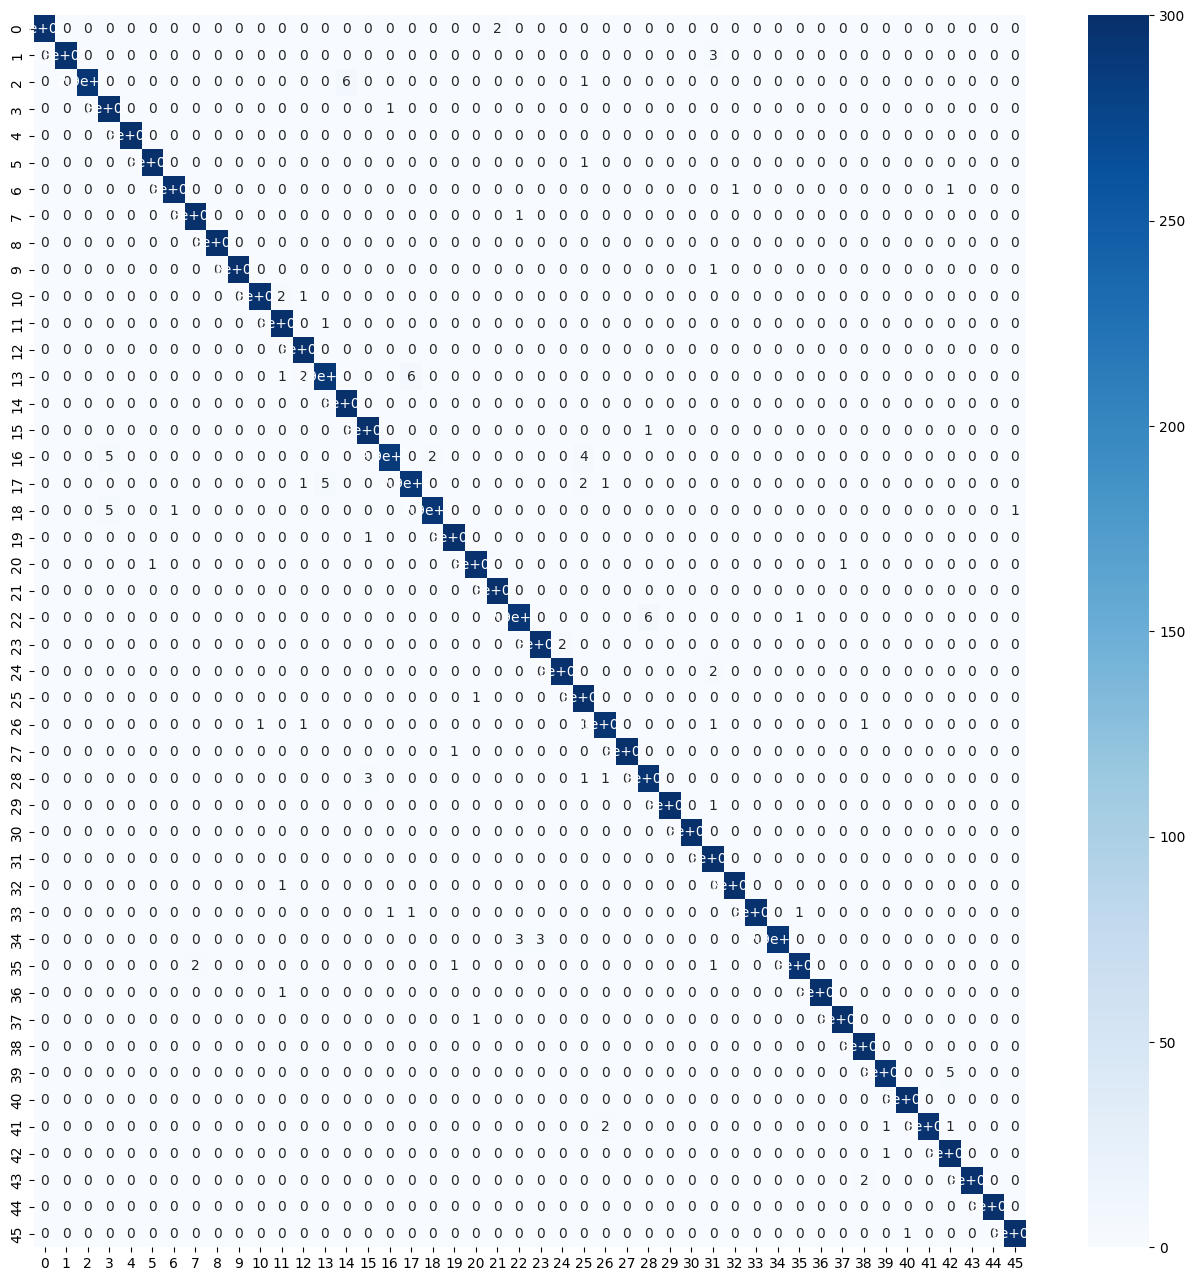

In [11]:
predicted_classes = np.argmax(model.predict(x_test), axis = 1)
confusionmatrix = confusion_matrix(np.argmax(y_test,axis=1), predicted_classes)
plt.figure(figsize = (16, 16))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True)
print(classification_report(np.argmax(y_test,axis=1), predicted_classes))

In [12]:
loss,acc = model.evaluate(x_test,y_test)

432/432 [==============================] - 59s 136ms/step - loss: 0.0317 - accuracy: 0.9917


In [13]:
import streamlit as st
import tensorflow as tf
# from tensorflow.keras.preprocessing import image
# from tensorflow.keras.applications.imagenet_utils import decode_predictions
import streamlit as st
# from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing import image
import numpy as np
from keras import backend as K

In [15]:

model = tf.keras.models.load_model('model-13-0.99-0.03.h5') 

In [16]:
def load_and_preprocess_image(uploaded_file):
    img_prd = load_img(uploaded_file,target_size=(48,48))
    img_prd = img_to_array(img_prd)
    img_pred = np.expand_dims(img_prd, axis=0)
    img_pred/= 255.0
    result = model.predict(img_pred)
    return result

In [17]:
file='Handwritten/DevanagariHandwrittenCharacterDataset/Test/digit_5/5437.png'
a=load_and_preprocess_image(file)
# print(a)
a1=max(a[0])
res=0
for i,j in enumerate(a[0]):
    if a1==j:
        res=i
        break

1/1 [==============================] - 0s 166ms/step


In [18]:
ch=['ka','kha','ga','gha','kna','cha','chha','ja','jha','yna','taamatar','thaa','daa','dhaa','adna','tabala','tha','da','dha','na','pa','pha','ba','bha','ma','yaw','ra','la','waw','motosaw','petchiryakha','patalosaw','ha','chhya','tra','gya','0','1','2','3','4','5','6','7','8','9']
print(ch[res])

5
